In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
! pip install transformers

In [4]:
!pip install --pre pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.2/487.2 kB 701.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 15.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 kB 15.2 MB/s et

In [5]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from tqdm import tqdm
# specify GPU
device = torch.device("cuda")

In [6]:
!pip install datasets 
from datasets import load_dataset
dataset = load_dataset("liar")

Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})


In [8]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

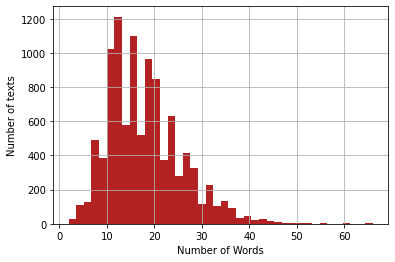

In [9]:
# Plot histogram of the number of words in train data 'title'
Text=dataset["train"]["statement"]
seq_len = [len(text.split()) for text in Text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [10]:

MAX_LENGHT = 100

# Tokenize and encode sequences in the train set
Text=dataset["train"]["statement"]
tokens_train = tokenizer.batch_encode_plus(
    Text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
Text=dataset["validation"]["statement"]
tokens_val = tokenizer.batch_encode_plus(
    Text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
Text=dataset["test"]["statement"]
tokens_test = tokenizer.batch_encode_plus(
    Text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [11]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(dataset["train"]["label"])

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(dataset["validation"]["label"])

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(dataset["test"]["label"])

In [12]:
print(len(val_seq),len(val_mask),len(val_y))
print(len(test_seq),len(test_mask),len(test_y))

print(len(train_seq),len(train_mask),len(train_y))
print(val_y)
print(len(dataset["validation"]["statement"]))
print()

1284 1284 1284
1283 1283 1283
10269 10269 10269
tensor([4, 5, 0,  ..., 3, 0, 4])
1284



In [13]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [14]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = True    # false here means gradient need not be computed

In [15]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,6)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 3

In [16]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(tqdm(train_dataloader)):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(tqdm(val_dataloader)):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [17]:
# Train and predict


best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in tqdm(range(epochs)):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'changed_weights_bert.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

  0%|          | 0/3 [00:00<?, ?it/s]


 Epoch 1 / 3



 16%|█▌        | 50/321 [13:04<1:08:56, 15.26s/it]

  Batch    50  of    321.



 31%|███       | 100/321 [26:08<56:48, 15.42s/it]

  Batch   100  of    321.



 47%|████▋     | 150/321 [39:02<44:04, 15.46s/it]

  Batch   150  of    321.



 62%|██████▏   | 200/321 [51:59<31:03, 15.40s/it]

  Batch   200  of    321.



 78%|███████▊  | 250/321 [1:04:51<18:01, 15.23s/it]

  Batch   250  of    321.



 93%|█████████▎| 300/321 [1:17:37<05:21, 15.33s/it]

  Batch   300  of    321.



100%|██████████| 321/321 [1:22:58<00:00, 15.51s/it]



Evaluating...



 33%|███▎      | 1/3 [1:26:14<2:52:28, 5174.49s/it]


Training Loss: 1.743
Validation Loss: 1.710

 Epoch 2 / 3



 16%|█▌        | 50/321 [12:46<1:09:39, 15.42s/it]

  Batch    50  of    321.



 31%|███       | 100/321 [25:37<59:01, 16.03s/it]

  Batch   100  of    321.



 47%|████▋     | 150/321 [38:34<44:48, 15.72s/it]

  Batch   150  of    321.



 62%|██████▏   | 200/321 [51:43<32:12, 15.97s/it]

  Batch   200  of    321.



 78%|███████▊  | 250/321 [1:04:46<18:18, 15.48s/it]

  Batch   250  of    321.



 93%|█████████▎| 300/321 [1:17:43<05:26, 15.53s/it]

  Batch   300  of    321.



100%|██████████| 321/321 [1:23:07<00:00, 15.54s/it]



Evaluating...



 67%|██████▋   | 2/3 [2:52:41<1:26:21, 5181.69s/it]


Training Loss: 1.682
Validation Loss: 1.719

 Epoch 3 / 3



 16%|█▌        | 50/321 [12:54<1:09:24, 15.37s/it]

  Batch    50  of    321.



 31%|███       | 100/321 [25:53<57:27, 15.60s/it]

  Batch   100  of    321.



 47%|████▋     | 150/321 [38:53<44:55, 15.76s/it]

  Batch   150  of    321.



 62%|██████▏   | 200/321 [51:49<31:17, 15.51s/it]

  Batch   200  of    321.



 78%|███████▊  | 250/321 [1:04:47<18:19, 15.48s/it]

  Batch   250  of    321.



 93%|█████████▎| 300/321 [1:17:45<05:19, 15.20s/it]

  Batch   300  of    321.



100%|██████████| 321/321 [1:23:10<00:00, 15.55s/it]



Evaluating...



100%|██████████| 3/3 [4:19:09<00:00, 5183.20s/it]  


Training Loss: 1.612
Validation Loss: 1.698


In [18]:
# load weights of best model
path = '/kaggle/working/changed_weights_bert.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [19]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.26      0.41      0.32       250
           1       0.29      0.38      0.33       267
           2       0.33      0.20      0.25       249
           3       0.30      0.32      0.31       211
           4       0.27      0.10      0.14       214
           5       0.32      0.27      0.29        92

    accuracy                           0.29      1283
   macro avg       0.29      0.28      0.27      1283
weighted avg       0.29      0.29      0.27      1283



In [20]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 100
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([5, 5, 0, 5])

In [21]:
import os 
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'changed_weights_bert.pt')

/kaggle/working


/kaggle/working/c2_new_model_weights.pt